Saving train_nn_double-predator.txt to train_nn_double-predator.txt
Saving train_nn_double-prey.txt to train_nn_double-prey.txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator.txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey.txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator.txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey.txt
Saving train_nn_per-predator.txt to train_nn_per-predator.txt
Saving train_nn_per-prey.txt to train_nn_per-prey.txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator.txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey.txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator.txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey.txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator.txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey.txt
Saving train_nn_radar_per-predator.txt to train_nn_radar_per

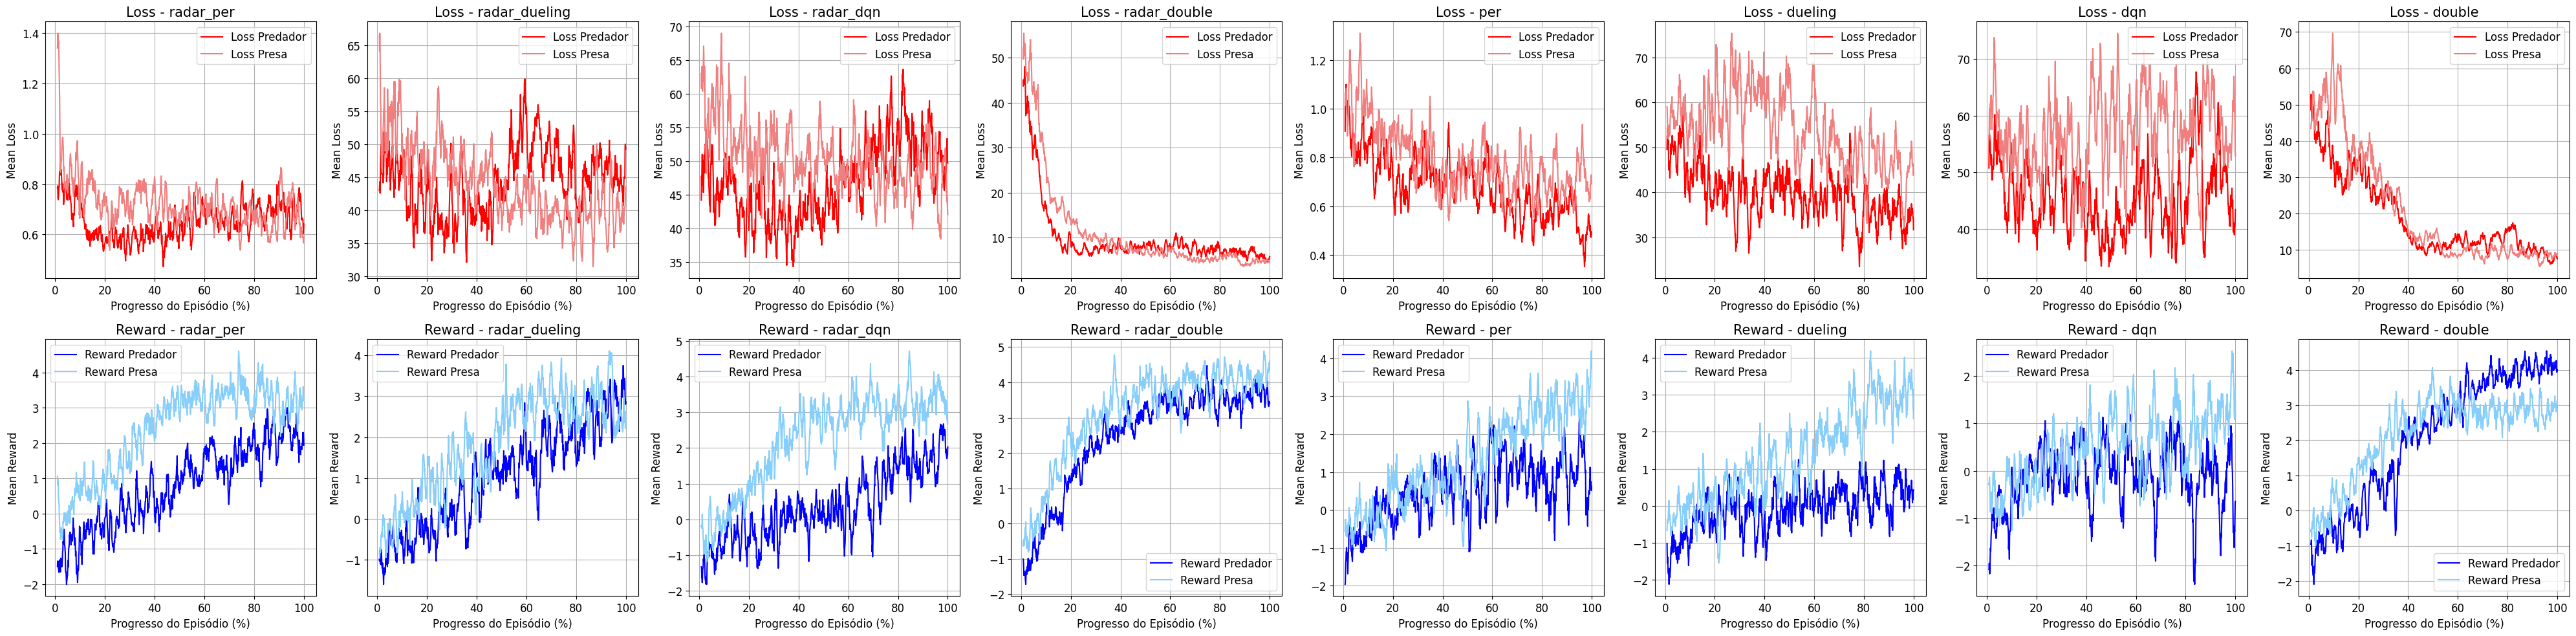

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Função para calcular média móvel
def calcular_media_movel(df, coluna, janela):
    return df[coluna].rolling(window=janela).mean()

# Função para processar arquivos
def processar_arquivo(filename):
    print(f"Processando arquivo: {filename}")

    # Determinar o tipo de agente
    tipo_agente = None
    if "predator" in filename.lower():
        tipo_agente = "predador"
    elif "prey" in filename.lower():
        tipo_agente = "presa"
    else:
        print(f"Arquivo '{filename}' não reconhecido como predador ou presa. Pulando...")
        return None, None

    # Extrair identificador do modelo
    try:
        file_identifier = filename.split("_", 2)[2].split("-")[0].replace("-", " ")
    except IndexError:
        print(f"Erro ao extrair identificador do arquivo '{filename}'.")
        file_identifier = "Desconhecido"

    # Carregar os dados
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

        # Filtrar linhas válidas e extrair dados
        data = []
        for line in lines:
            if "Episode:" in line:
                parts = line.split(",")

                # Extração dos valores corretos com base nas palavras-chave
                try:
                    episode = int(parts[0].split(":")[1].strip())
                    mean_loss = float(next(part.split(":")[1].strip() for part in parts if "Mean Loss:" in part))
                    mean_reward = float(next(part.split(":")[1].strip() for part in parts if "Mean Reward:" in part))

                    # Adicionar os dados extraídos
                    data.append([episode, mean_loss, mean_reward])
                except (IndexError, ValueError, StopIteration) as e:
                    print(f"Erro ao processar linha: {line}. Detalhes: {e}")
                    continue


        # Criar o DataFrame
        df = pd.DataFrame(data, columns=["Episode", "Mean Loss", "Mean Reward"])
        return file_identifier, df
    except Exception as e:
        print(f"Erro ao processar o arquivo '{filename}': {e}")
        return None, None

# Upload dos arquivos
uploaded = files.upload()

# Parâmetros de média móvel
janela_loss = 10
janela_reward = 10

# Dicionário para armazenar dados agrupados
data_pairs = {}

# Processar cada arquivo
for filename in uploaded.keys():
    file_identifier, df = processar_arquivo(filename)
    if file_identifier and df is not None:
        # Calcular médias móveis
        df["Smoothed Loss"] = calcular_media_movel(df, "Mean Loss", janela_loss)
        df["Smoothed Reward"] = calcular_media_movel(df, "Mean Reward", janela_reward)

        # Organizar por identificador e tipo de agente
        if file_identifier not in data_pairs:
            data_pairs[file_identifier] = {"predador": None, "presa": None}
        role = "predador" if "predator" in filename.lower() else "presa"
        data_pairs[file_identifier][role] = df

# Preparar os gráficos
# Preparar os gráficos
# Preparar os gráficos
n_models = len(data_pairs)

# Configurar tamanhos de fonte
plt.rcParams.update({
    'font.size': 12,  # Tamanho geral da fonte
    'axes.titlesize': 15,  # Tamanho dos títulos dos eixos
    'axes.labelsize': 12,  # Tamanho dos rótulos dos eixos
    'xtick.labelsize': 12,  # Tamanho dos rótulos do eixo X
    'ytick.labelsize': 12,  # Tamanho dos rótulos do eixo Y
    'legend.fontsize': 12,  # Tamanho da fonte da legenda
})

fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 10))


# Iterar pelos dados na ordem inversa
for idx, (model_identifier, data) in enumerate(reversed(data_pairs.items())):
    if data["predador"] is not None and data["presa"] is not None:
        predador_df = data["predador"]
        presa_df = data["presa"]

        # Normalizar os episódios para porcentagem
        max_episode = max(predador_df['Episode'].max(), presa_df['Episode'].max())
        predador_df['Episode %'] = (predador_df['Episode'] / max_episode) * 100
        presa_df['Episode %'] = (presa_df['Episode'] / max_episode) * 100

        # Gráfico de Loss
        ax_loss = axes[0, idx]
        ax_loss.plot(predador_df['Episode %'], predador_df['Smoothed Loss'], label='Loss Predador', color='red')
        ax_loss.plot(presa_df['Episode %'], presa_df['Smoothed Loss'], label='Loss Presa', color='lightcoral')
        ax_loss.set_title(f"Loss - {model_identifier}")
        ax_loss.set_xlabel("Progresso do Episódio (%)")
        ax_loss.set_ylabel("Mean Loss")
        ax_loss.set_xticks(range(0, 101, 20))  # Marcas de 20% em 20%
        ax_loss.legend()
        ax_loss.grid()

        # Gráfico de Reward
        ax_reward = axes[1, idx]
        ax_reward.plot(predador_df['Episode %'], predador_df['Smoothed Reward'], label='Reward Predador', color='blue')
        ax_reward.plot(presa_df['Episode %'], presa_df['Smoothed Reward'], label='Reward Presa', color='lightskyblue')
        ax_reward.set_title(f"Reward - {model_identifier}")
        ax_reward.set_xlabel("Progresso do Episódio (%)")
        ax_reward.set_ylabel("Mean Reward")
        ax_reward.set_xticks(range(0, 101, 20))  # Marcas de 20% em 20%
        ax_reward.legend()
        ax_reward.grid()
    else:
        print(f"Dados incompletos para o modelo '{model_identifier}'.")

# Ajustar o layout
plt.tight_layout()
plt.show()



SOMENTE LOSS

Saving train_nn_double-predator.txt to train_nn_double-predator (1).txt
Saving train_nn_double-prey.txt to train_nn_double-prey (1).txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator (1).txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey (1).txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator (1).txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey (1).txt
Saving train_nn_per-predator.txt to train_nn_per-predator (1).txt
Saving train_nn_per-prey.txt to train_nn_per-prey (1).txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator (1).txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey (1).txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator (1).txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey (1).txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator (1).txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey (1).txt
Savi

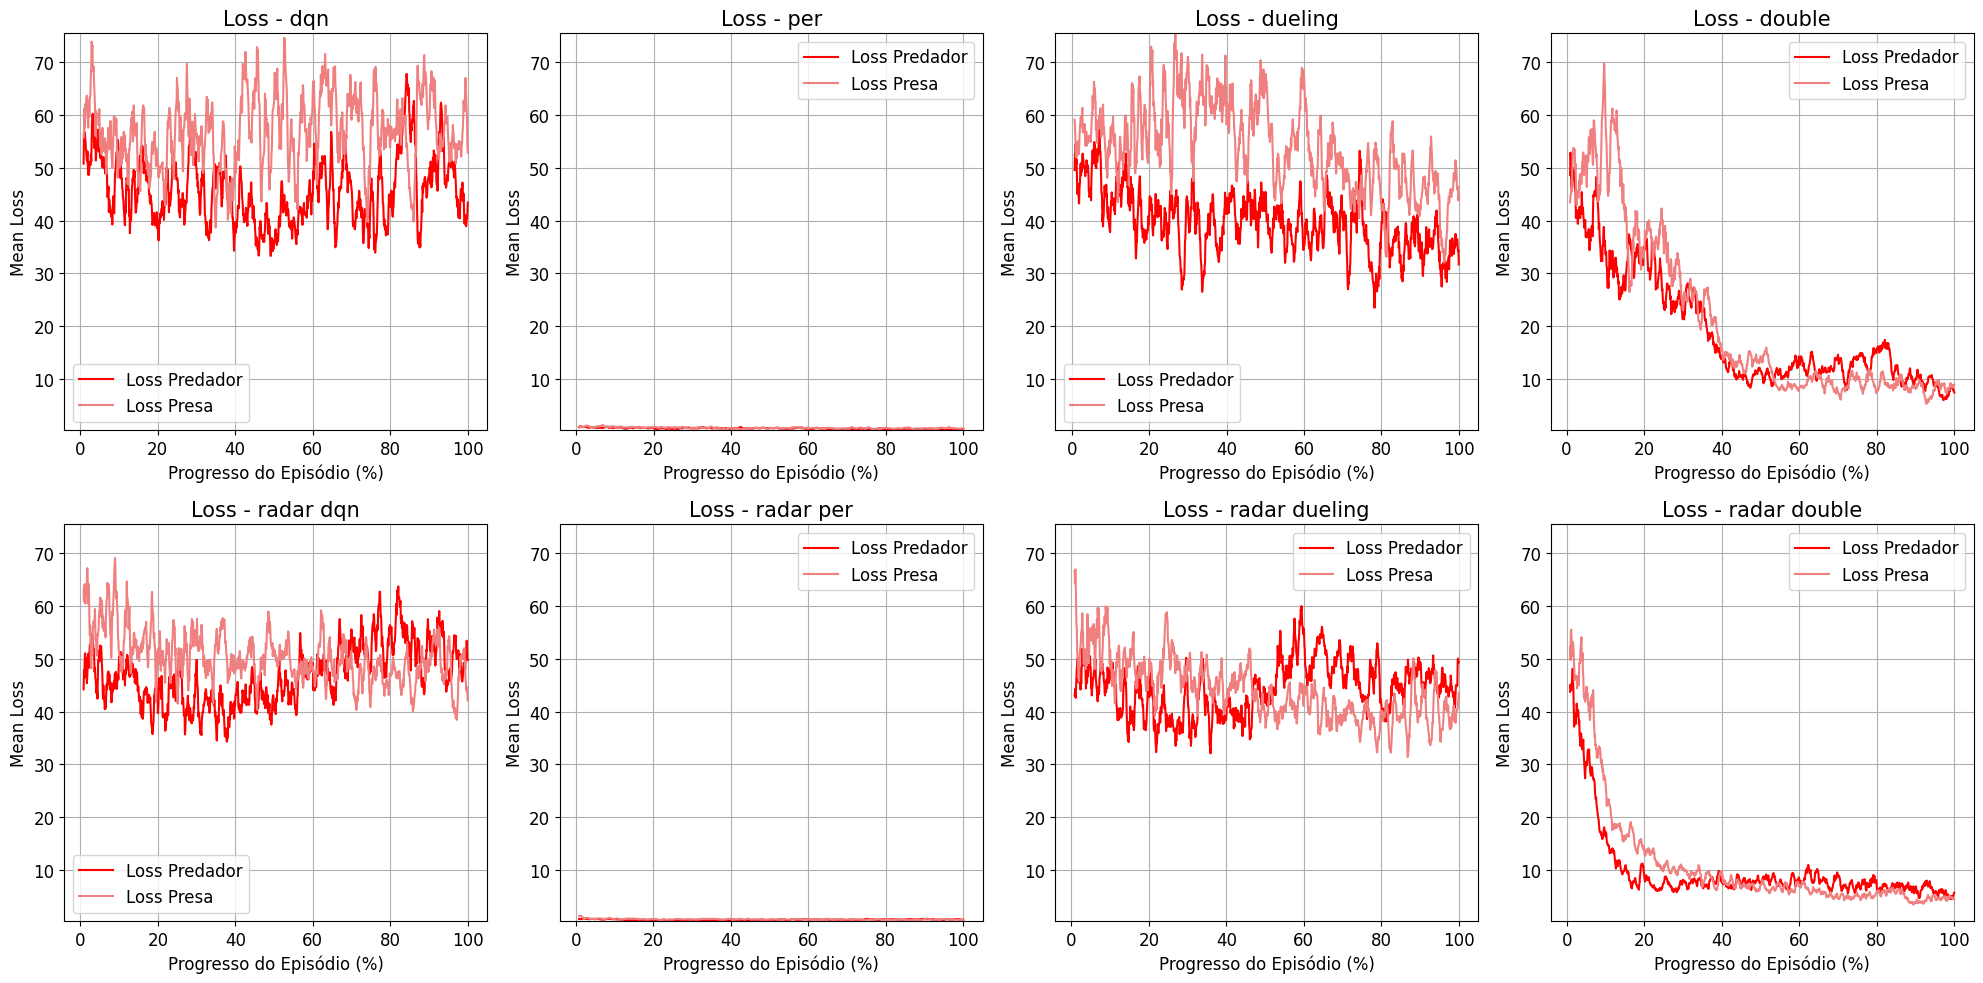

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Função para média móvel
def calcular_media_movel(df, coluna, janela):
    return df[coluna].rolling(window=janela).mean()

# Mapeamento dos prefixos dos arquivos para nomes amigáveis
mapeamento_prefixos = {
    "train_nn_dqn": "dqn",
    "train_nn_per": "per",
    "train_nn_dueling": "dueling",
    "train_nn_double": "double",
    "train_nn_radar_dqn": "radar dqn",
    "train_nn_radar_per": "radar per",
    "train_nn_radar_dueling": "radar dueling",
    "train_nn_radar_double": "radar double"
}

# Função de processamento
def processar_arquivo(filename):
    print(f"Processando arquivo: {filename}")

    if "predator" in filename.lower():
        tipo_agente = "predador"
    elif "prey" in filename.lower():
        tipo_agente = "presa"
    else:
        print(f"Arquivo '{filename}' não reconhecido como predador ou presa. Pulando...")
        return None, None

    # Extrair prefixo base
    for prefixo in mapeamento_prefixos:
        if filename.startswith(prefixo):
            file_identifier = mapeamento_prefixos[prefixo]
            break
    else:
        file_identifier = "desconhecido"

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

        data = []
        for line in lines:
            if "Episode:" in line:
                parts = line.split(",")
                try:
                    episode = int(parts[0].split(":")[1].strip())
                    mean_loss = float(next(part.split(":")[1].strip() for part in parts if "Mean Loss:" in part))
                    data.append([episode, mean_loss])
                except Exception as e:
                    continue

        df = pd.DataFrame(data, columns=["Episode", "Mean Loss"])
        return file_identifier, tipo_agente, df
    except Exception as e:
        print(f"Erro ao processar o arquivo '{filename}': {e}")
        return None, None, None

# Upload dos arquivos
uploaded = files.upload()

# Média móvel
janela_loss = 10
data_pairs = {}

# Processar todos os arquivos
for filename in uploaded.keys():
    file_identifier, tipo_agente, df = processar_arquivo(filename)
    if file_identifier and df is not None:
        df["Smoothed Loss"] = calcular_media_movel(df, "Mean Loss", janela_loss)
        if file_identifier not in data_pairs:
            data_pairs[file_identifier] = {"predador": None, "presa": None}
        data_pairs[file_identifier][tipo_agente] = df

# Ordem desejada
ordem_modelos = [
    "dqn", "per", "dueling", "double",
    "radar dqn", "radar per", "radar dueling", "radar double"
]

# Escala Y global
min_loss = float("inf")
max_loss = float("-inf")
for modelo in data_pairs.values():
    for tipo in ["predador", "presa"]:
        df = modelo[tipo]
        if df is not None:
            min_loss = min(min_loss, df["Smoothed Loss"].min(skipna=True))
            max_loss = max(max_loss, df["Smoothed Loss"].max(skipna=True))

# Gráficos
n_models = len(ordem_modelos)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

# Gerar os subplots em layout 2x4
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Permite acesso sequencial aos 8 subplots

for idx, modelo_nome in enumerate(ordem_modelos):
    if modelo_nome in data_pairs:
        data = data_pairs[modelo_nome]
        if data["predador"] is not None and data["presa"] is not None:
            predador_df = data["predador"]
            presa_df = data["presa"]

            max_episode = max(predador_df['Episode'].max(), presa_df['Episode'].max())
            predador_df['Episode %'] = (predador_df['Episode'] / max_episode) * 100
            presa_df['Episode %'] = (presa_df['Episode'] / max_episode) * 100

            ax = axes[idx]
            ax.plot(predador_df['Episode %'], predador_df['Smoothed Loss'], label='Loss Predador', color='red')
            ax.plot(presa_df['Episode %'], presa_df['Smoothed Loss'], label='Loss Presa', color='lightcoral')
            ax.set_title(f"Loss - {modelo_nome}")
            ax.set_xlabel("Progresso do Episódio (%)")
            ax.set_ylabel("Mean Loss")
            ax.set_xticks(range(0, 101, 20))
            ax.set_ylim(min_loss, max_loss)
            ax.legend()
            ax.grid()
        else:
            print(f"Dados incompletos para o modelo '{modelo_nome}'.")
    else:
        print(f"Modelo '{modelo_nome}' não encontrado.")

plt.tight_layout()
plt.show()


Saving train_nn_double-predator.txt to train_nn_double-predator (1).txt
Saving train_nn_double-prey.txt to train_nn_double-prey (1).txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator (1).txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey (1).txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator (1).txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey (1).txt
Saving train_nn_per-predator.txt to train_nn_per-predator (1).txt
Saving train_nn_per-prey.txt to train_nn_per-prey (1).txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator (1).txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey (1).txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator (1).txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey (1).txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator (1).txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey (1).txt
Savi

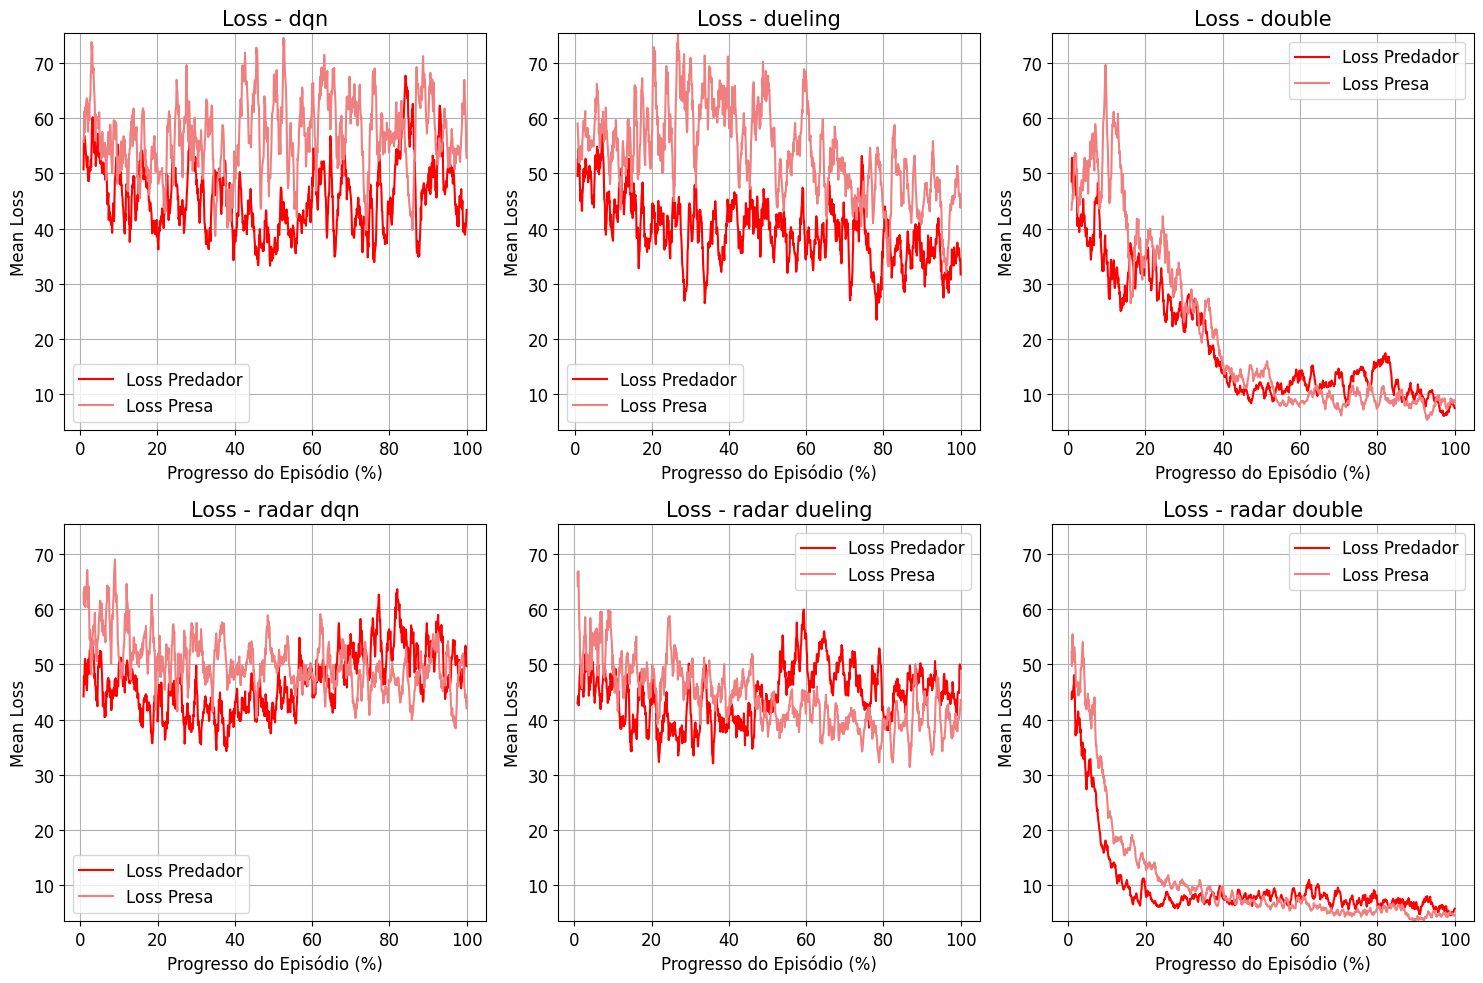

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Função para média móvel
def calcular_media_movel(df, coluna, janela):
    return df[coluna].rolling(window=janela).mean()

# Mapeamento dos prefixos dos arquivos para nomes amigáveis
mapeamento_prefixos = {
    "train_nn_dqn": "dqn",
    "train_nn_per": "per",  # ainda será processado, mas não exibido
    "train_nn_dueling": "dueling",
    "train_nn_double": "double",
    "train_nn_radar_dqn": "radar dqn",
    "train_nn_radar_per": "radar per",  # idem
    "train_nn_radar_dueling": "radar dueling",
    "train_nn_radar_double": "radar double"
}

# Função de processamento
def processar_arquivo(filename):
    print(f"Processando arquivo: {filename}")

    if "predator" in filename.lower():
        tipo_agente = "predador"
    elif "prey" in filename.lower():
        tipo_agente = "presa"
    else:
        print(f"Arquivo '{filename}' não reconhecido como predador ou presa. Pulando...")
        return None, None, None

    for prefixo in mapeamento_prefixos:
        if filename.startswith(prefixo):
            file_identifier = mapeamento_prefixos[prefixo]
            break
    else:
        file_identifier = "desconhecido"

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

        data = []
        for line in lines:
            if "Episode:" in line:
                parts = line.split(",")
                try:
                    episode = int(parts[0].split(":")[1].strip())
                    mean_loss = float(next(part.split(":")[1].strip() for part in parts if "Mean Loss:" in part))
                    data.append([episode, mean_loss])
                except Exception as e:
                    continue

        df = pd.DataFrame(data, columns=["Episode", "Mean Loss"])
        return file_identifier, tipo_agente, df
    except Exception as e:
        print(f"Erro ao processar o arquivo '{filename}': {e}")
        return None, None, None

# Upload dos arquivos
uploaded = files.upload()

# Média móvel
janela_loss = 10
data_pairs = {}

# Processar todos os arquivos
for filename in uploaded.keys():
    file_identifier, tipo_agente, df = processar_arquivo(filename)
    if file_identifier and df is not None:
        df["Smoothed Loss"] = calcular_media_movel(df, "Mean Loss", janela_loss)
        if file_identifier not in data_pairs:
            data_pairs[file_identifier] = {"predador": None, "presa": None}
        data_pairs[file_identifier][tipo_agente] = df

# Ordem dos modelos sem PER
ordem_modelos = [
    "dqn", "dueling", "double",
    "radar dqn", "radar dueling", "radar double"
]

# Escala Y global
min_loss = float("inf")
max_loss = float("-inf")
for modelo_nome in ordem_modelos:
    if modelo_nome in data_pairs:
        for tipo in ["predador", "presa"]:
            df = data_pairs[modelo_nome][tipo]
            if df is not None:
                min_loss = min(min_loss, df["Smoothed Loss"].min(skipna=True))
                max_loss = max(max_loss, df["Smoothed Loss"].max(skipna=True))

# Layout 2x3
n_models = len(ordem_modelos)
n_linhas, n_colunas = 2, 3

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(5 * n_colunas, 5 * n_linhas))
axes = axes.flatten()

for idx, modelo_nome in enumerate(ordem_modelos):
    if modelo_nome in data_pairs:
        data = data_pairs[modelo_nome]
        if data["predador"] is not None and data["presa"] is not None:
            predador_df = data["predador"]
            presa_df = data["presa"]

            max_episode = max(predador_df['Episode'].max(), presa_df['Episode'].max())
            predador_df['Episode %'] = (predador_df['Episode'] / max_episode) * 100
            presa_df['Episode %'] = (presa_df['Episode'] / max_episode) * 100

            ax = axes[idx]
            ax.plot(predador_df['Episode %'], predador_df['Smoothed Loss'], label='Loss Predador', color='red')
            ax.plot(presa_df['Episode %'], presa_df['Smoothed Loss'], label='Loss Presa', color='lightcoral')
            ax.set_title(f"Loss - {modelo_nome}")
            ax.set_xlabel("Progresso do Episódio (%)")
            ax.set_ylabel("Mean Loss")
            ax.set_xticks(range(0, 101, 20))
            ax.set_ylim(min_loss, max_loss)
            ax.legend()
            ax.grid()
        else:
            print(f"Dados incompletos para o modelo '{modelo_nome}'.")

plt.tight_layout()
plt.show()


REWARD

Saving train_nn_double-predator.txt to train_nn_double-predator (2).txt
Saving train_nn_double-prey.txt to train_nn_double-prey (2).txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator (2).txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey (2).txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator (2).txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey (2).txt
Saving train_nn_per-predator.txt to train_nn_per-predator (2).txt
Saving train_nn_per-prey.txt to train_nn_per-prey (2).txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator (2).txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey (2).txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator (2).txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey (2).txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator (2).txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey (2).txt
Savi

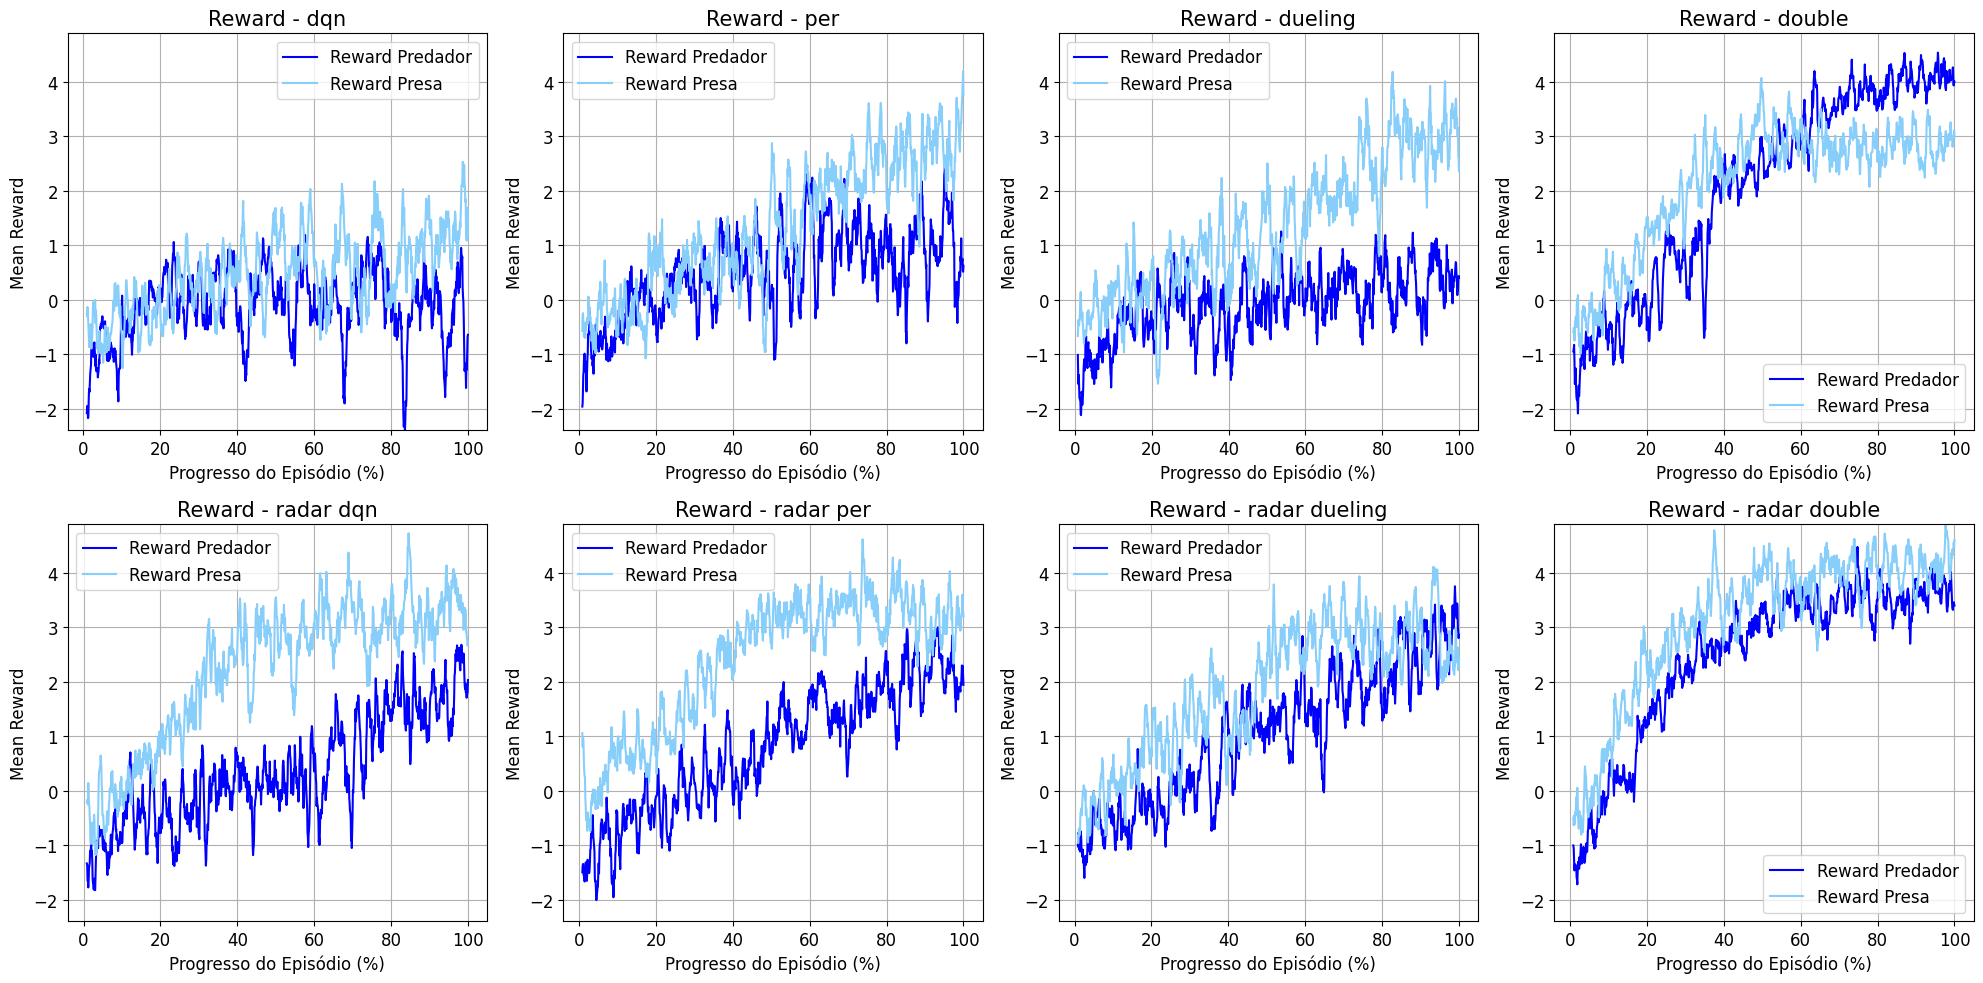

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Função para média móvel
def calcular_media_movel(df, coluna, janela):
    return df[coluna].rolling(window=janela).mean()

# Mapeamento dos prefixos dos arquivos para nomes amigáveis
mapeamento_prefixos = {
    "train_nn_dqn": "dqn",
    "train_nn_per": "per",
    "train_nn_dueling": "dueling",
    "train_nn_double": "double",
    "train_nn_radar_dqn": "radar dqn",
    "train_nn_radar_per": "radar per",
    "train_nn_radar_dueling": "radar dueling",
    "train_nn_radar_double": "radar double"
}

# Função de processamento
def processar_arquivo(filename):
    print(f"Processando arquivo: {filename}")

    if "predator" in filename.lower():
        tipo_agente = "predador"
    elif "prey" in filename.lower():
        tipo_agente = "presa"
    else:
        print(f"Arquivo '{filename}' não reconhecido como predador ou presa. Pulando...")
        return None, None, None

    for prefixo in mapeamento_prefixos:
        if filename.startswith(prefixo):
            file_identifier = mapeamento_prefixos[prefixo]
            break
    else:
        file_identifier = "desconhecido"

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

        data = []
        for line in lines:
            if "Episode:" in line:
                parts = line.split(",")
                try:
                    episode = int(parts[0].split(":")[1].strip())
                    mean_reward = float(next(part.split(":")[1].strip() for part in parts if "Mean Reward:" in part))
                    data.append([episode, mean_reward])
                except Exception:
                    continue

        df = pd.DataFrame(data, columns=["Episode", "Mean Reward"])
        return file_identifier, tipo_agente, df
    except Exception as e:
        print(f"Erro ao processar o arquivo '{filename}': {e}")
        return None, None, None

# Upload dos arquivos
uploaded = files.upload()

# Parâmetros de média móvel
janela_reward = 10
data_pairs = {}

# Processar arquivos
for filename in uploaded.keys():
    file_identifier, tipo_agente, df = processar_arquivo(filename)
    if file_identifier and df is not None:
        df["Smoothed Reward"] = calcular_media_movel(df, "Mean Reward", janela_reward)
        if file_identifier not in data_pairs:
            data_pairs[file_identifier] = {"predador": None, "presa": None}
        data_pairs[file_identifier][tipo_agente] = df

# Ordem dos modelos
ordem_modelos = [
    "dqn", "per", "dueling", "double",
    "radar dqn", "radar per", "radar dueling", "radar double"
]

# Escala Y global
min_reward = float("inf")
max_reward = float("-inf")
for modelo in data_pairs.values():
    for tipo in ["predador", "presa"]:
        df = modelo[tipo]
        if df is not None:
            min_reward = min(min_reward, df["Smoothed Reward"].min(skipna=True))
            max_reward = max(max_reward, df["Smoothed Reward"].max(skipna=True))

# Gráficos 2x4
n_models = len(ordem_modelos)
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, modelo_nome in enumerate(ordem_modelos):
    if modelo_nome in data_pairs:
        data = data_pairs[modelo_nome]
        if data["predador"] is not None and data["presa"] is not None:
            predador_df = data["predador"]
            presa_df = data["presa"]

            max_episode = max(predador_df['Episode'].max(), presa_df['Episode'].max())
            predador_df['Episode %'] = (predador_df['Episode'] / max_episode) * 100
            presa_df['Episode %'] = (presa_df['Episode'] / max_episode) * 100

            ax = axes[idx]
            ax.plot(predador_df['Episode %'], predador_df['Smoothed Reward'], label='Reward Predador', color='blue')
            ax.plot(presa_df['Episode %'], presa_df['Smoothed Reward'], label='Reward Presa', color='lightskyblue')
            ax.set_title(f"Reward - {modelo_nome}")
            ax.set_xlabel("Progresso do Episódio (%)")
            ax.set_ylabel("Mean Reward")
            ax.set_xticks(range(0, 101, 20))
            ax.set_ylim(min_reward, max_reward)
            ax.legend()
            ax.grid()
        else:
            print(f"Dados incompletos para o modelo '{modelo_nome}'.")
    else:
        print(f"Modelo '{modelo_nome}' não encontrado.")

plt.tight_layout()
plt.show()


Saving train_nn_double-predator.txt to train_nn_double-predator.txt
Saving train_nn_double-prey.txt to train_nn_double-prey.txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator.txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey.txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator.txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey.txt
Saving train_nn_per-predator.txt to train_nn_per-predator.txt
Saving train_nn_per-prey.txt to train_nn_per-prey.txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator.txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey.txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator.txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey.txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator.txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey.txt
Saving train_nn_radar_per-predator.txt to train_nn_radar_per

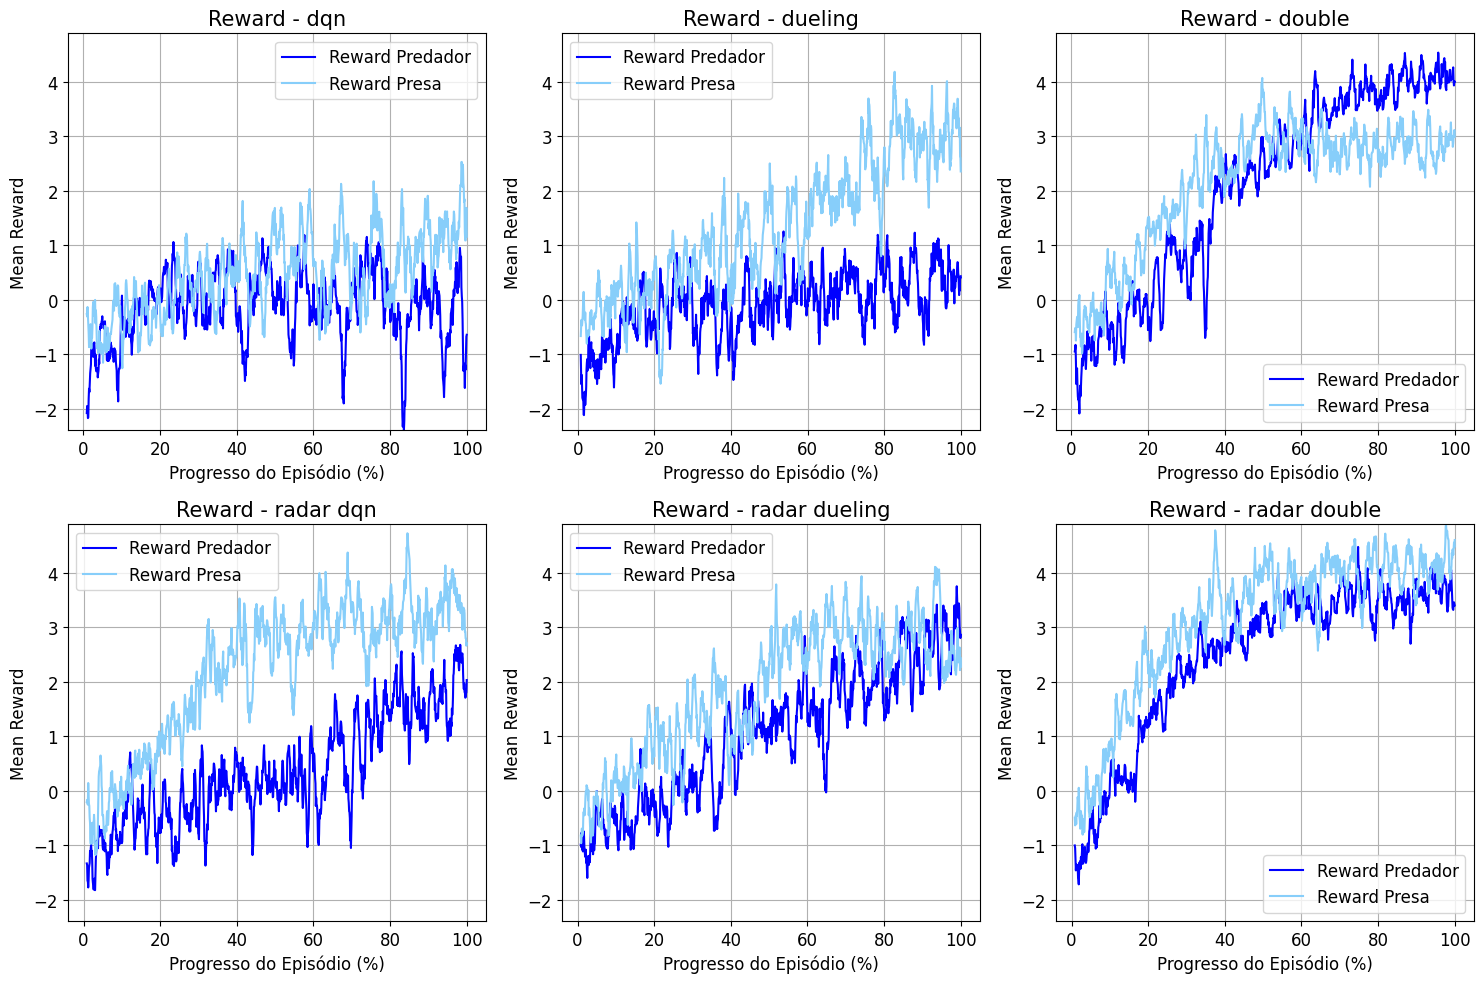

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Função para média móvel
def calcular_media_movel(df, coluna, janela):
    return df[coluna].rolling(window=janela).mean()

# Mapeamento dos prefixos dos arquivos para nomes amigáveis
mapeamento_prefixos = {
    "train_nn_dqn": "dqn",
    "train_nn_per": "per",  # ainda processa, mas não plota
    "train_nn_dueling": "dueling",
    "train_nn_double": "double",
    "train_nn_radar_dqn": "radar dqn",
    "train_nn_radar_per": "radar per",  # ainda processa, mas não plota
    "train_nn_radar_dueling": "radar dueling",
    "train_nn_radar_double": "radar double"
}

# Função de processamento
def processar_arquivo(filename):
    print(f"Processando arquivo: {filename}")

    if "predator" in filename.lower():
        tipo_agente = "predador"
    elif "prey" in filename.lower():
        tipo_agente = "presa"
    else:
        print(f"Arquivo '{filename}' não reconhecido como predador ou presa. Pulando...")
        return None, None, None

    for prefixo in mapeamento_prefixos:
        if filename.startswith(prefixo):
            file_identifier = mapeamento_prefixos[prefixo]
            break
    else:
        file_identifier = "desconhecido"

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

        data = []
        for line in lines:
            if "Episode:" in line:
                parts = line.split(",")
                try:
                    episode = int(parts[0].split(":")[1].strip())
                    mean_reward = float(next(part.split(":")[1].strip() for part in parts if "Mean Reward:" in part))
                    data.append([episode, mean_reward])
                except Exception:
                    continue

        df = pd.DataFrame(data, columns=["Episode", "Mean Reward"])
        return file_identifier, tipo_agente, df
    except Exception as e:
        print(f"Erro ao processar o arquivo '{filename}': {e}")
        return None, None, None

# Upload dos arquivos
uploaded = files.upload()

# Parâmetros de média móvel
janela_reward = 10
data_pairs = {}

# Processar arquivos
for filename in uploaded.keys():
    file_identifier, tipo_agente, df = processar_arquivo(filename)
    if file_identifier and df is not None:
        df["Smoothed Reward"] = calcular_media_movel(df, "Mean Reward", janela_reward)
        if file_identifier not in data_pairs:
            data_pairs[file_identifier] = {"predador": None, "presa": None}
        data_pairs[file_identifier][tipo_agente] = df

# Ordem dos modelos (PER removido)
ordem_modelos = [
    "dqn", "dueling", "double",
    "radar dqn", "radar dueling", "radar double"
]

# Escala Y global
min_reward = float("inf")
max_reward = float("-inf")
for modelo_nome in ordem_modelos:
    if modelo_nome in data_pairs:
        for tipo in ["predador", "presa"]:
            df = data_pairs[modelo_nome][tipo]
            if df is not None:
                min_reward = min(min_reward, df["Smoothed Reward"].min(skipna=True))
                max_reward = max(max_reward, df["Smoothed Reward"].max(skipna=True))

# Gráficos: ajuste layout para 2 linhas e 3 colunas (6 modelos)
n_models = len(ordem_modelos)
n_linhas = 2
n_colunas = 3

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(5 * n_colunas, 5 * n_linhas))
axes = axes.flatten()

for idx, modelo_nome in enumerate(ordem_modelos):
    if modelo_nome in data_pairs:
        data = data_pairs[modelo_nome]
        if data["predador"] is not None and data["presa"] is not None:
            predador_df = data["predador"]
            presa_df = data["presa"]

            max_episode = max(predador_df['Episode'].max(), presa_df['Episode'].max())
            predador_df['Episode %'] = (predador_df['Episode'] / max_episode) * 100
            presa_df['Episode %'] = (presa_df['Episode'] / max_episode) * 100

            ax = axes[idx]
            ax.plot(predador_df['Episode %'], predador_df['Smoothed Reward'], label='Reward Predador', color='blue')
            ax.plot(presa_df['Episode %'], presa_df['Smoothed Reward'], label='Reward Presa', color='lightskyblue')
            ax.set_title(f"Reward - {modelo_nome}")
            ax.set_xlabel("Progresso do Episódio (%)")
            ax.set_ylabel("Mean Reward")
            ax.set_xticks(range(0, 101, 20))
            ax.set_ylim(min_reward, max_reward)
            ax.legend()
            ax.grid()
        else:
            print(f"Dados incompletos para o modelo '{modelo_nome}'.")

plt.tight_layout()
plt.show()


In [2]:
import random
from google.colab import files

# Fazer upload dos arquivos
print("Por favor, envie os arquivos para processamento.")
uploaded = files.upload()

# Processar cada arquivo enviado
for nome_arquivo_original in uploaded.keys():
    # Ler o arquivo original
    with open(nome_arquivo_original, 'r') as arquivo:
        linhas = arquivo.readlines()

    # Agrupar linhas por episódios
    episodios = {}
    for linha in linhas:
        if linha.startswith("Episode"):
            numero = int(linha.split(",")[0].split(":")[1].strip())
            episodios.setdefault(numero // 5, []).append(linha)  # Agrupa em blocos de 5

    # Processar os grupos de episódios
    novo_conteudo = []
    novo_indice = 0
    for grupo in episodios.values():
        if len(grupo) > 0:
            # Selecionar uma linha aleatoriamente
            linha_selecionada = random.choice(grupo)
            # Atualizar o número do episódio na linha selecionada
            linha_modificada = linha_selecionada.replace(
                f"Episode: {linha_selecionada.split(':')[1].split(',')[0].strip()}",
                f"Episode: {novo_indice}"
            )
            novo_conteudo.append(linha_modificada)
            novo_indice += 1

    # Nome do novo arquivo
    nome_arquivo_novo = nome_arquivo_original.replace(".txt", "_1000.txt")

    # Salvar o novo arquivo
    with open(nome_arquivo_novo, 'w') as novo_arquivo:
        novo_arquivo.writelines(novo_conteudo)

    print(f"Arquivo processado e salvo como {nome_arquivo_novo}")

    # Disponibilizar para download
    files.download(nome_arquivo_novo)


Por favor, envie os arquivos para processamento.


Saving train_nn_double-predator.txt to train_nn_double-predator (1).txt
Saving train_nn_double-prey.txt to train_nn_double-prey (1).txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator (1).txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey (1).txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator (1).txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey (1).txt
Saving train_nn_per-predator.txt to train_nn_per-predator (1).txt
Saving train_nn_per-prey.txt to train_nn_per-prey (1).txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator (1).txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey (1).txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator (1).txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey (1).txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator (1).txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey (1).txt
Savi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_double-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_dqn-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_dqn-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_dueling-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_dueling-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_per-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_per-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_double-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_double-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_dqn-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_dqn-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_dueling-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_dueling-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_per-predator (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Arquivo processado e salvo como train_nn_radar_per-prey (1)_1000.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import random
from google.colab import files

#limpa de 4000 para 10000


# Fazer upload dos arquivos
print("Por favor, envie os arquivos para processamento.")
uploaded = files.upload()

# Processar cada arquivo enviado
for nome_arquivo_original in uploaded.keys():
    # Ler o arquivo original
    with open(nome_arquivo_original, 'r') as arquivo:
        linhas = arquivo.readlines()

    # Agrupar linhas por episódios
    episodios = {}
    for linha in linhas:
        if linha.startswith("Episode"):
            numero = int(linha.split(",")[0].split(":")[1].strip())
            episodios.setdefault(numero // 4, []).append(linha)

    # Processar os grupos de episódios
    novo_conteudo = []
    novo_indice = 0
    for grupo in episodios.values():
        if len(grupo) > 1:
            # Selecionar uma linha aleatoriamente
            linha_selecionada = random.choice(grupo)
            linha_modificada = linha_selecionada.replace(f"Episode: {linha_selecionada.split(':')[1].split(',')[0].strip()}", f"Episode: {novo_indice}")
            novo_conteudo.append(linha_modificada)
            novo_indice += 1

    # Nome do novo arquivo
    nome_arquivo_novo = nome_arquivo_original.replace(".txt", "_1000.txt")

    # Salvar o novo arquivo
    with open(nome_arquivo_novo, 'w') as novo_arquivo:
        novo_arquivo.writelines(novo_conteudo)

    print(f"Arquivo processado e salvo como {nome_arquivo_novo}")

    # Disponibilizar para download
    files.download(nome_arquivo_novo)


In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import re
from google.colab import files

# Função para processar os arquivos e gerar estatísticas
def process_files(uploaded_files):
    feedback_patterns = [
        '[PREDATOR]: Alvo capturado',
        '[PREDATOR]: Proximidade aliado: 1.',
        '[PREDATOR]: Proximidade aliado: 2.',
        '[PREDATOR]: Proximidade aliado: 3.',
        '[PREDATOR]: Proximidade presa: 1.',
        '[PREDATOR]: Proximidade presa: 2.',
        '[PREDATOR]: Proximidade presa: 3.',
        '[PREY]: Evasão do alvo!',
        '[PREY]: Proximidade aliado: 1.',
        '[PREY]: Proximidade aliado: 2.',
        '[PREY]: Proximidade aliado: 3.',
        '[PREY]: Proximidade predador: 1.',
        '[PREY]: Proximidade predador: 2.',
        '[PREY]: Proximidade predador: 3.'
    ]

    summary_rows = []

    for file_name, file_content in uploaded_files.items():
        # Converter os bytes do arquivo para um DataFrame
        from io import BytesIO
        data = pd.read_csv(BytesIO(file_content), sep="\t", engine='python', header=None)

        # Nome do arquivo sem extensão
        base_name = file_name.replace('.txt', '')

        # Total de episódios e média de steps por episódio
        episodes = data[0].str.extract(r'(\d+)/(\d+):')[0].astype(int).max() + 1
        steps_per_episode = data[0].str.extract(r'(\d+)/(\d+):')[1].astype(int).groupby(data[0].str.extract(r'(\d+)/')[0]).max()
        mean_steps = steps_per_episode.mean()

        # Contar ocorrências de feedbacks por episódio
        feedback_counts = {feedback: [] for feedback in feedback_patterns}

        for episode in range(episodes):
            episode_data = data[data[0].str.startswith(f"{episode}/")]
            feedback_texts = episode_data[0].str.extract(r'Feedback: (.*)')[0].dropna()

            for feedback in feedback_patterns:
                feedback_counts[feedback].append(feedback_texts.str.contains(re.escape(feedback)).sum())

        # Calcular estatísticas por tipo de feedback e organizar os dados
        feedback_summary = {}
        for feedback, counts in feedback_counts.items():
            counts = np.array(counts)
            feedback_summary[f"mean_{feedback}"] = np.mean(counts)
            feedback_summary[f"median_{feedback}"] = np.median(counts)
            feedback_summary[f"std_{feedback}"] = np.std(counts)

        # Adicionar linha ao resumo
        summary_row = {
            'file_name': base_name,
            'total_episodes': episodes,
            'mean_steps': mean_steps,
        }
        summary_row.update(feedback_summary)
        summary_rows.append(summary_row)

    # Retornar todos os dados como um DataFrame
    return pd.DataFrame(summary_rows)

# Fazer upload dos arquivos
uploaded_files = files.upload()

# Processar os arquivos
summary_df = process_files(uploaded_files)

# Exibir o DataFrame final no Colab
from IPython.display import display
display(summary_df)


In [3]:
# Importar as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import re

######## GRAFICO

# Função para processar o arquivo de texto
def processar_dados(caminho_arquivo):
    dados = {
        "Episode": [],
        "Std Loss": [],
        "Std Reward": []
    }

    # Ler o arquivo linha por linha
    with open(caminho_arquivo, 'r') as arquivo:
        for linha in arquivo:
            match = re.search(r"Episode: (\d+).*Std Loss: ([\d.-]+).*Std Reward: ([\d.-]+)", linha)
            if match:
                dados["Episode"].append(int(match.group(1)))
                dados["Std Loss"].append(float(match.group(2)))
                dados["Std Reward"].append(float(match.group(3)))

    return pd.DataFrame(dados)

# Função para calcular a média móvel
def calcular_media_movel(dados, coluna, janela):
    return dados[coluna].rolling(window=janela).mean()

# Fazer upload dos arquivos
from google.colab import files

print("Por favor, envie os arquivos de dados (formato .txt)")
uploaded = files.upload()

# Processar arquivos com base no prefixo
janela_loss = 50  # Tamanho da janela da média móvel para Loss
janela_reward = 50  # Tamanho da janela da média móvel para Reward


# Organizar os arquivos em pares com base no prefixo
arquivos_por_prefixo = {}
for nome in uploaded.keys():
    # Remover a extensão e o sufixo do tipo MIME
    nome_limpo = re.sub(r'\.txt\(.*\)$', '', nome)
    prefixo, tipo = nome_limpo.rsplit('-', 1)  # Separar no último '-'
    if prefixo not in arquivos_por_prefixo:
        arquivos_por_prefixo[prefixo] = {}
    arquivos_por_prefixo[prefixo][tipo] = nome




# Permitir ao usuário definir a ordem dos prefixos
ordem_desejada = [
    "train_nn_radar_dqn",
    "train_nn_radar_dqn_per",
    "train_nn_radar_dqn_dueling",
    "train_nn_radar_dqn_double",
]



# Garantir que a ordem siga a lista fornecida pelo usuário
prefixos_ordenados = [p for p in ordem_desejada if p in arquivos_por_prefixo]

# Figura para Loss e Reward combinados
plt.figure(figsize=(20, 5 * len(prefixos_ordenados) // 2))
for idx in range(0, len(prefixos_ordenados), 2):
    prefixo_base = prefixos_ordenados[idx]
    prefixo_tunning = prefixos_ordenados[idx + 1] if idx + 1 < len(prefixos_ordenados) else None

    # Loss - Base
    plt.subplot(len(prefixos_ordenados) // 2, 4, (idx // 2) * 4 + 1)
    arquivos = arquivos_por_prefixo[prefixo_base]
    dados_presa = processar_dados(arquivos.get('prey')) if 'prey' in arquivos else None
    dados_predador = processar_dados(arquivos.get('predator')) if 'predator' in arquivos else None
    if dados_presa is not None:
        dados_presa["Porcentagem"] = (dados_presa["Episode"] / dados_presa["Episode"].max()) * 100
        dados_presa["Media Movel Std Loss"] = calcular_media_movel(dados_presa, "Std Loss", janela_loss)
        plt.plot(dados_presa["Porcentagem"], dados_presa["Media Movel Std Loss"], label="Presa", color="lightcoral", linewidth=1)
    if dados_predador is not None:
        dados_predador["Porcentagem"] = (dados_predador["Episode"] / dados_predador["Episode"].max()) * 100
        dados_predador["Media Movel Std Loss"] = calcular_media_movel(dados_predador, "Std Loss", janela_loss)
        plt.plot(dados_predador["Porcentagem"], dados_predador["Media Movel Std Loss"], label="Predador", color="darkred", linewidth=1)
    plt.title(f"Loss - {prefixo_base}")
    plt.xlabel("% do Treinamento")
    plt.ylabel("Loss")
    plt.legend()


    # Reward - Base
    plt.subplot(len(prefixos_ordenados) // 2, 4, (idx // 2) * 4 + 3)
    arquivos = arquivos_por_prefixo[prefixo_base]
    dados_presa = processar_dados(arquivos.get('prey')) if 'prey' in arquivos else None
    dados_predador = processar_dados(arquivos.get('predator')) if 'predator' in arquivos else None
    if dados_presa is not None:
        dados_presa["Porcentagem"] = (dados_presa["Episode"] / dados_presa["Episode"].max()) * 100
        dados_presa["Media Movel Std Reward"] = calcular_media_movel(dados_presa, "Std Reward", janela_reward)
        plt.plot(dados_presa["Porcentagem"], dados_presa["Media Movel Std Reward"], label="Presa", color="lightskyblue", linewidth=1)
    if dados_predador is not None:
        dados_predador["Porcentagem"] = (dados_predador["Episode"] / dados_predador["Episode"].max()) * 100
        dados_predador["Media Movel Std Reward"] = calcular_media_movel(dados_predador, "Std Reward", janela_reward)
        plt.plot(dados_predador["Porcentagem"], dados_predador["Media Movel Std Reward"], label="Predador", color="darkblue", linewidth=1)
    plt.title(f"Reward - {prefixo_base}")
    plt.xlabel("% do Treinamento")
    plt.ylabel("Reward")
    plt.legend()



plt.tight_layout()
plt.show()


Por favor, envie os arquivos de dados (formato .txt)


Saving train_nn_double-predator.txt to train_nn_double-predator (2).txt
Saving train_nn_double-prey.txt to train_nn_double-prey (2).txt
Saving train_nn_dqn-predator.txt to train_nn_dqn-predator (2).txt
Saving train_nn_dqn-prey.txt to train_nn_dqn-prey (2).txt
Saving train_nn_dueling-predator.txt to train_nn_dueling-predator (2).txt
Saving train_nn_dueling-prey.txt to train_nn_dueling-prey (2).txt
Saving train_nn_per-predator.txt to train_nn_per-predator (2).txt
Saving train_nn_per-prey.txt to train_nn_per-prey (2).txt
Saving train_nn_radar_double-predator.txt to train_nn_radar_double-predator (2).txt
Saving train_nn_radar_double-prey.txt to train_nn_radar_double-prey (2).txt
Saving train_nn_radar_dqn-predator.txt to train_nn_radar_dqn-predator (2).txt
Saving train_nn_radar_dqn-prey.txt to train_nn_radar_dqn-prey (2).txt
Saving train_nn_radar_dueling-predator.txt to train_nn_radar_dueling-predator (2).txt
Saving train_nn_radar_dueling-prey.txt to train_nn_radar_dueling-prey (2).txt
Savi

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2000x200 with 0 Axes>

In [ ]:
import re
import pandas as pd
from google.colab import files

# Função para processar cada arquivo e extrair estatísticas
def process_file(file_content, file_name):
    # Determina se os dados estão associados a "prey" ou "predator"
    if "Total Reward (prey)" in file_content:
        target = "prey"
    elif "Total Reward (predator)" in file_content:
        target = "predator"
    else:
        print(f"Formato desconhecido no arquivo: {file_name}")
        return None

    # Expressão regular para capturar as informações de cada linha
    pattern = rf"Episode: (\d+), Step: (\d+), Population \(Prey/Predator\): (\d+)/(\d+), Total Reward \({target}\): ([\d.-]+), Total Dones \({target}\): (\d+)"

    # Extrai as informações usando regex
    matches = re.findall(pattern, file_content)

    if not matches:
        print(f"Nenhum dado encontrado no arquivo: {file_name}")
        return None

    # Converte os dados extraídos para um DataFrame
    data = pd.DataFrame(matches, columns=[
        "Episode", "Step", "Population_Prey", "Population_Predator", "Total_Reward", "Total_Dones"
    ])

    # Converte os dados para os tipos apropriados
    data = data.astype({
        "Episode": int,
        "Step": int,
        "Population_Prey": int,
        "Population_Predator": int,
        "Total_Reward": float,
        "Total_Dones": int
    })

    # Calcula as estatísticas
    stats = {
        "File Name": file_name,
        "Total Episodes": len(data),
        "Mean Steps": data["Step"].mean(),
        "Median Steps": data["Step"].median(),
        "Step Std Dev": data["Step"].std(),
        "Prey Mean": data["Population_Prey"].mean(),
        "Prey Median": data["Population_Prey"].median(),
        "Prey Std Dev": data["Population_Prey"].std(),
        "Predator Mean": data["Population_Predator"].mean(),
        "Predator Median": data["Population_Predator"].median(),
        "Predator Std Dev": data["Population_Predator"].std(),
        "Reward Mean": data["Total_Reward"].mean(),
        "Reward Median": data["Total_Reward"].median(),
        "Reward Std Dev": data["Total_Reward"].std(),
        "Dones Mean": data["Total_Dones"].mean(),
        "Dones Median": data["Total_Dones"].median(),
        "Dones Std Dev": data["Total_Dones"].std(),
    }

    return stats

# Carrega arquivos para processamento
uploaded_files = files.upload()

# Lista para armazenar os resultados de cada arquivo
results = []

# Processa cada arquivo carregado
for file_name, file_content in uploaded_files.items():
    file_content_str = file_content.decode("utf-8")
    stats = process_file(file_content_str, file_name)
    if stats:  # Ignora arquivos que não foram processados
        results.append(stats)

# Converte os resultados para um DataFrame para melhor visualização
results_df = pd.DataFrame(results)

# Exibe o DataFrame
from IPython.display import display
display(results_df)


In [ ]:
import re
from collections import Counter
from google.colab import files

def count_non_number_lines_from_uploaded_file():
    # Fazendo upload do arquivo
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]

    # Compilando o padrão para identificar linhas que começam com números
    pattern = re.compile(r"^\d+/\d+")

    # Lendo o arquivo
    with open(file_name, "r", encoding="utf-8") as file:
        lines = file.readlines()

    # Filtrando linhas que não começam com números
    non_number_lines = [line.strip() for line in lines if not pattern.match(line)]

    # Contando as ocorrências de cada linha única
    line_counts = Counter(non_number_lines)

    # Retornando o total de cada frase
    return dict(line_counts)

# Chamando a função e imprimindo os resultados
result = count_non_number_lines_from_uploaded_file()

print("Frequência de frases que não começam com números:\n")
for phrase, count in result.items():
    print(f'"{phrase}": {count} ocorrências')


In [ ]:
import re
from collections import Counter
from google.colab import files

def count_specific_phrases():
    # Fazendo upload do arquivo
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]

    # Lendo o arquivo
    with open(file_name, "r", encoding="utf-8") as file:
        lines = file.readlines()

    # Frases a serem contadas
    phrases = [
        "[PREDATOR]: Proximidade presa: 1",
        "[PREDATOR]: Proximidade presa: 2",
        "[PREDATOR]: Proximidade presa: 3",
        "[PREDATOR]: Alvo capturado",
        "[PREDATOR]: Explorando mapa.",
        "[PREDATOR]: Proximidade aliado: 1",
        "[PREDATOR]: Proximidade aliado: 2",
        "[PREDATOR]: Proximidade aliado: 3",
        "[PREY]: Proximidade predador: 1",
        "[PREY]: Proximidade predador: 2",
        "[PREY]: Proximidade predador: 3",
        "[PREY]: Evasão do alvo",
        "[PREY]: Explorando mapa",
        "[PREY]: Proximidade aliado: 1",
        "[PREY]: Proximidade aliado: 2",
        "[PREY]: Proximidade aliado: 3"
    ]

    # Inicializando o contador
    phrase_counts = {phrase: 0 for phrase in phrases}

    # Contando as ocorrências de cada frase
    for line in lines:
        for phrase in phrases:
            if phrase in line:
                phrase_counts[phrase] += 1

    # Retornando os resultados
    return phrase_counts

# Chamando a função e imprimindo os resultados
result = count_specific_phrases()

print("Contagem de ocorrências para cada frase especificada:\n")
for phrase, count in result.items():
    print(f'"{phrase}": {count} ocorrências')


In [ ]:
# Código para extrair coordenadas únicas por episódio e calcular estatísticas no Colab

# Importando bibliotecas necessárias
from google.colab import files
import numpy as np

# Realizando o upload do arquivo para o Colab
uploaded = files.upload()

# Pegando o nome do arquivo após o upload
file_name = list(uploaded.keys())[0]

# Dicionários para armazenar coordenadas únicas por episódio
coordinates_breed_0_by_episode = {}
coordinates_breed_2_by_episode = {}

# Abrindo e processando o arquivo
with open(file_name, 'r') as file:
    for line in file:
        if "Position:" in line:
            # Extraindo o episódio e passo (e.g., "0/0", "1/2")
            episode_step = line.split(":")[0].strip()
            episode = episode_step.split("/")[0]  # Pegando apenas o episódio

            # Extraindo as coordenadas entre parênteses
            start_index = line.find("Position: (") + len("Position: (")
            end_index = line.find(")", start_index)
            if start_index > -1 and end_index > -1:
                coord = line[start_index:end_index].strip()

                # Verificando se a linha contém Breed:0 ou Breed:2
                if "Breed:0" in line:
                    if episode not in coordinates_breed_0_by_episode:
                        coordinates_breed_0_by_episode[episode] = set()
                    coordinates_breed_0_by_episode[episode].add(coord)
                elif "Breed:2" in line:
                    if episode not in coordinates_breed_2_by_episode:
                        coordinates_breed_2_by_episode[episode] = set()
                    coordinates_breed_2_by_episode[episode].add(coord)

# Calculando estatísticas para Breed:0
breed_0_lengths = [len(coords) for coords in coordinates_breed_0_by_episode.values()]
breed_0_mean = np.mean(breed_0_lengths)
breed_0_median = np.median(breed_0_lengths)
breed_0_std = np.std(breed_0_lengths)

# Calculando estatísticas para Breed:2
breed_2_lengths = [len(coords) for coords in coordinates_breed_2_by_episode.values()]
breed_2_mean = np.mean(breed_2_lengths)
breed_2_median = np.median(breed_2_lengths)
breed_2_std = np.std(breed_2_lengths)

# Exibindo os resultados
print(f"Estatísticas para Breed:0:")
print(f"Média: {breed_0_mean}")
print(f"Mediana: {breed_0_median}")
print(f"Desvio Padrão: {breed_0_std}\n")

print(f"Estatísticas para Breed:2:")
print(f"Média: {breed_2_mean}")
print(f"Mediana: {breed_2_median}")
print(f"Desvio Padrão: {breed_2_std}")
